## Data exploration:
1. Extract json content to dataframe (panda)
2. Basic statictics analysis on the data
3. Conclusion

### Usefull links
- [dataset](https://signate.jp/competitions/256/data)
- [signate tuto](https://signate.jp/competitions/142/tutorials/9)
- [frame extraction - signate](https://signate.jp/competitions/256/discussions/tutorial-how-to-decode-the-training-videos-to-training-images)
- [frame label to yolo format-signate](https://signate.jp/competitions/256/discussions/tutorial-how-to-convert-labels-from-multiple-jsons-to-a-single-txt-file)
- [panda and list as cat](https://stackoverflow.com/questions/37125174/accessing-every-1st-element-of-pandas-dataframe-column-containing-lists)
- [team google docs](https://docs.google.com/document/d/1UPNw9wHmnnpVCJI8LBmBkJG1lyKzn-Hhh1flNZ5k2Eo/edit)

In [1]:
import os
import pandas as pd
import numpy as np
import json

### 1] Extract json to dataframe

In [2]:
# Generate one file for all video
## Get absolute path / or specify path for data
_path_for_data = "../data/"
train_annotations_path = os.path.join(_path_for_data, 'train_annotations')
train_annotations_files = os.listdir(train_annotations_path)

In [3]:
# Global parameters (note the spelling on Svehicle)
IMAGE_SIZE = (1936,1216)
IMAGE_AREA = IMAGE_SIZE[0]*IMAGE_SIZE[1]
CATEGORIES = ['Car', 'Pedestrian', 'Truck', 'Signal', 'Signs', 'Bicycle', 'Motorbike', 'Bus', 'Svehicle', 'Train']

# Dataframe content:
column_names = ["video_id", "frame_id", "detected_cat", "tracking_id", "bbox"]
annot_df = pd.DataFrame(columns = column_names)

Extract of 1 video by 1 video, because 600x25 is too heavy to process as once.

Here we extract in order::
1. The frames
2. The frame_id
3. The detected category
4. Tracking index and bbox

In [4]:
def extract_frame(frame, content_list, video_id, frame_id):
    """Extract the content of the frame into the df dataframe."""
    for classe in CATEGORIES:
        try:
            for detected_cat in frame[classe]:
                # Add line to df
                content_list.append({"video_id":video_id, 
                                    "frame_id":frame_id,
                                    "detected_cat":classe, 
                                    "tracking_id":detected_cat['id'], 
                                    "bbox":detected_cat['box2d']})
        except Exception as e:
            pass

In [ ]:
# Load from csv:
annot_df = pd.read_csv("../data/annot_df_sig.csv")

In [5]:
# Or load from file
for train_annotations_file in train_annotations_files:
    content_list = []
    with open(os.path.join(train_annotations_path, train_annotations_file)) as f:
        video_id = train_annotations_file.split('/')[-1].split('\\')[-1].split('.')[0].split('_')[1]

        # Load json and split frame
        annotation = json.load(f)
        frames = annotation["sequence"]
        print("Extracting video train_{} a total of {} frames...".format(video_id, len(frames)))

        # Extract each frame content into dataset
        for frame_id, frame in enumerate(frames):
            extract_frame(frame, content_list, video_id, frame_id)

        # Writting in the dataframe
        annot_df = annot_df.append(content_list)
        print("...Done!")

Extracting video train_09 a total of 600 frames...
...Done!
Extracting video train_01 a total of 600 frames...
...Done!
Extracting video train_10 a total of 600 frames...
...Done!
Extracting video train_13 a total of 600 frames...
...Done!
Extracting video train_06 a total of 600 frames...
...Done!
Extracting video train_14 a total of 600 frames...
...Done!
Extracting video train_23 a total of 600 frames...
...Done!
Extracting video train_12 a total of 600 frames...
...Done!
Extracting video train_02 a total of 600 frames...
...Done!
Extracting video train_24 a total of 600 frames...
...Done!
Extracting video train_00 a total of 600 frames...
...Done!
Extracting video train_21 a total of 600 frames...
...Done!
Extracting video train_07 a total of 600 frames...
...Done!
Extracting video train_16 a total of 600 frames...
...Done!
Extracting video train_03 a total of 600 frames...
...Done!
Extracting video train_05 a total of 600 frames...
...Done!
Extracting video train_11 a total of 600

### 3] WIP Basic exploration

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
print("Shape of Dataframe: {}".format(annot_df.shape))
print(annot_df.info())

Shape of Dataframe: (306057, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 306057 entries, 0 to 7118
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   video_id      306057 non-null  object
 1   frame_id      306057 non-null  object
 2   detected_cat  306057 non-null  object
 3   tracking_id   306057 non-null  object
 4   bbox          306057 non-null  object
dtypes: object(5)
memory usage: 14.0+ MB
None


In [8]:
# Generate area and ratio features
annot_df['area'] = (annot_df.bbox.str[2] - annot_df.bbox.str[0])*(annot_df.bbox.str[3] - annot_df.bbox.str[1])
annot_df['ratio'] = round(annot_df['area'] / IMAGE_AREA * 100, 4) 

In [9]:
annot_df.head()

,video_id,frame_id,detected_cat,tracking_id,bbox,area,ratio
0,09,0,Car,5598,"[1825, 577, 1935, 671]",10340,0.4392
1,09,0,Car,5538,"[1181, 486, 1762, 897]",238791,10.1433
2,09,0,Car,5597,"[1099, 579, 1196, 713]",12998,0.5521
3,09,0,Car,5502,"[812, 583, 1088, 820]",65412,2.7786
4,09,0,Car,5596,"[1047, 552, 1158, 660]",11988,0.5092


In [10]:
# Chekc bbox position:
# To verify: no object to be detected in [0-400] pix (box2d: [x1, y1, x2, y2])
annot_df['x_min'] = annot_df.bbox.str[0]
annot_df['x_max'] = annot_df.bbox.str[2]
annot_df['y_min'] = annot_df.bbox.str[1]
annot_df['y_max'] = annot_df.bbox.str[3]

In [ ]:
annot_df

In [ ]:
# create all list
x_list = []
y_list = []
x_list.append(annot_df.x_min)
x_list.append(annot_df.x_max)
y_list.append(annot_df.y_min)
y_list.append(annot_df.y_max)

all_x = x_list[0] + x_list[1]
all_y = y_list[0] + y_list[1]

In [ ]:
annot_df.y_min.hist()

In [ ]:
annot_df.y_max.hist()

In [ ]:
annot_df.x_min.hist()

In [ ]:
annot_df.x_max.hist()

In [ ]:
annot_df.to_csv(_path_for_data + '/annot_df.csv', encoding='utf-8-sig')

In [ ]:
annot_df['detected_cat'].value_counts().plot(kind='bar',x='cat',y='count', title="Detected on ALL VIDEO - tracking id ignored")

In [ ]:
annot_df.head()

In [17]:
# Analysis for 1 video
# Find the importante features to extract and then run on all video
vid_00 = annot_df.loc[annot_df.video_id=='00']
vid_01 = annot_df.loc[annot_df.video_id=='01']
vid_02 = annot_df.loc[annot_df.video_id=='02']
vid_03 = annot_df.loc[annot_df.video_id=='03']
vid_04 = annot_df.loc[annot_df.video_id=='04']
vid_05 = annot_df.loc[annot_df.video_id=='05']
vid_06 = annot_df.loc[annot_df.video_id=='06']
vid_07 = annot_df.loc[annot_df.video_id=='07']
vid_08 = annot_df.loc[annot_df.video_id=='08']
vid_09 = annot_df.loc[annot_df.video_id=='09']
vid_10 = annot_df.loc[annot_df.video_id=='10']
vid_11 = annot_df.loc[annot_df.video_id=='11']
vid_12 = annot_df.loc[annot_df.video_id=='12']
vid_13 = annot_df.loc[annot_df.video_id=='13']
vid_18 = annot_df.loc[annot_df.video_id=='18']
vid_22 = annot_df.loc[annot_df.video_id=='22']

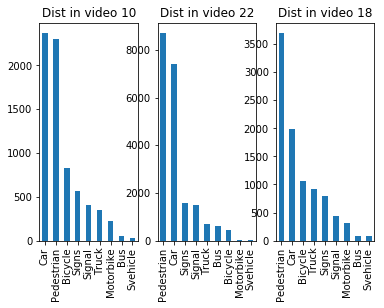

In [27]:
# Plot repartition
fig, axs = plt.subplots(1,3)
vid_10['detected_cat'].value_counts().plot(ax=axs[0], kind='bar',x='cat',y='count', title="Dist in video 10")
vid_22['detected_cat'].value_counts().plot(ax=axs[1], kind='bar',x='cat',y='count', title="Dist in video 22")
vid_18['detected_cat'].value_counts().plot(ax=axs[2], kind='bar',x='cat',y='count', title="Dist in video 18")

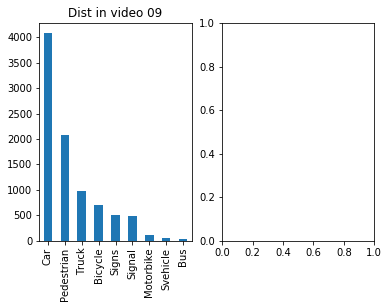

In [30]:
fig, axs = plt.subplots(1,2)
vid_09['detected_cat'].value_counts().plot(ax=axs[0], kind='bar',x='cat',y='count', title="Dist in video 09")


In [22]:
print("Number of detected object and unique ID:")
print("    Video_10, detection {} for {} unique ID".format(vid_00.shape[0], vid_10['tracking_id'].nunique()))
print("    Video_18: detection {} for {} unique ID".format(vid_01.shape[0], vid_18['tracking_id'].nunique()))


Number of detected object and unique ID:
    Video_10, detection 8885 for 483 unique ID
    Video_18: detection 9704 for 457 unique ID


In [20]:
print("Bbox ratio/image averages: vid_10 {}".format(round(vid_10.ratio.mean(), 3)))
print("Bbox ratio/image averages: vid_22 {}".format(round(vid_22.ratio.mean(), 3)))


Bbox ratio/image averages: vid_10 0.412
Bbox ratio/image averages: vid_22 0.484


In [ ]:
bins

In [ ]:
vid_01['detected_cat'].value_counts().plot(kind='bar',x='cat',y='count', title="Detected on video 01 - tracking id ignored")

In [ ]:
vid_02['detected_cat'].value_counts().plot(kind='bar',x='cat',y='count', title="Detected on video 02 - tracking id ignored")

In [ ]:
selected_video['detected_cat'].value_counts().plot(kind='bar',x='cat',y='count', title="Detected on video 15 - tracking id ignored")

In [ ]:
# How many object by frame / without size filtering
max_detected = annot_df.groupby(['video_id','frame_id']).detected_cat.count().max()
min_detected = annot_df.groupby(['video_id','frame_id']).detected_cat.count().min()
ave_detected = annot_df.groupby(['video_id','frame_id']).detected_cat.count().mean()
print("Detection by frame: average: {} | max: {} | min: {}".format(ave_detected, max_detected, min_detected))

In [ ]:
# Filter area size criteria 1024 square pixel:
annot_df['Area_threshold'] = annot_df['area'].apply(lambda x: True if x >= 1024 else False)

In [ ]:
annot_df['Area_threshold'].value_counts()

In [ ]:
# Check for car and pedestrian
annot_df.loc[annot_df['detected_cat'].isin(['Car', 'Pedestrian'])].Area_threshold.value_counts()

In [ ]:
# Average ratio bbox by class
annot_df.groupby('detected_cat').ratio.mean()

In [ ]:
# Find unique ID - without filtering
unique_id = annot_df.groupby('video_id')['tracking_id'].nunique()
print("List of number of distincs object for each video:")
print(unique_id)

In [ ]:
# Count repeated tracking id
# "Objects with 3 or more frames in each video"
reapeate_more_than_3 = selected_video.groupby('tracking_id').tracking_id.count().apply(lambda x: True if x>2 else False)
print("There are {} objects that are not repeated more than 3 times.".format(reapeate_more_than_3.values.tolist().count(False)))

In [ ]:
# Longuest repeatition
selected_video.groupby('tracking_id').tracking_id.count().nlargest(10)

In [ ]:
print("One car is tracked in all frame of the video - maybe need to check the video")
selected_video.loc[selected_video['tracking_id'] == 5686].head()

In [ ]:
# Other analysis?
# - tracking id lenght / class
# - ??
# Objects with 3 or more frames in each image
# Objects with a rectangle size of 1024 pix² or more ??

In [ ]:
tracking_grouped = selected_video.groupby(['tracking_id'])
frame_list = tracking_grouped.aggregate(lambda x: tuple(x)).frame_id

In [ ]:
def check_obstruction(frame_list):
    return not (sorted(frame_list) == list( range( min(frame_list), max(frame_list)+1 ) ) )

In [ ]:
obstructions = frame_list.apply(lambda x: check_obstruction(x))

In [ ]:
obstructions

In [ ]:
annot_df.head()

## Conlusion

### Category repartition:
![all_video](all_video.png) ![15](more_car15.png)

- Unbalance repartition in the data is not an issue if the same repartition appear in the test set.
See: [prior probability](https://www.investopedia.com/terms/p/prior_probability.asp)

- Note than in some video the repartition car-pedestrian is inversed (ex video 15) or more equal (eg: video 02)

### Frame

Detection by frame average on all video: average: 20.4038 | max: 94 | min: 1.

### Area size
The area threshold of 1024 is quite important on the dataset:
- On the full data, **True: 199178 /False:106879**
- On Car - Pedestrian only, **True: 143552 / False: 71963**

### Tracking ID
Tracking ID in the train set seems to be a bit tricky as some object_id doesn't appear 3 times in the dataset.

Note of obstruction: Obstruction does appear in the dataset. If needed I can spend more time to find information (how often in the dataset / which category / size /...)
